<a href="https://colab.research.google.com/github/Yeeeens/Big-data-2023/blob/main/GW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#All imports
#import sys
#!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 
import numpy
import pycbc
import pycbc.types
import pylab
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np

In [ ]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2023-03-12 16:35:43--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  32.9MB/s    in 1.7s    

2023-03-12 16:35:45 (32.9 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-12 16:35:45--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  34.9MB/s    in 1.7s    

20

In [ ]:
#Load data
d = numpy.load('/content/drive/MyDrive/noise_ts_4096Hz.npy')
dt = d[:, 0]
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries

#merger = Merger("GW170817")
strain, stilde = {}, {}
strain = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)
strain = strain.crop(4, 4)
stilde = strain.to_frequencyseries()



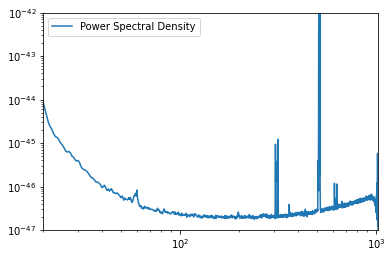

In [ ]:
import pycbc.psd
from pycbc.psd import interpolate

psds = {}


delta_t = strain.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(strain,
                  seg_len=seg_len,
                  seg_stride=seg_stride)
    
psds = interpolate(psds, stilde.delta_f)

pylab.loglog(psds.sample_frequencies, psds, label = "Power Spectral Density" )
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()

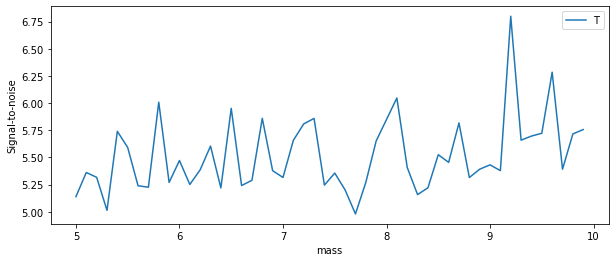

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

mass1 = numpy.arange(5, 10 , 0.10 ) #mass range bewteen 1 to 3 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain,
                     psd=psds, low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr= snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr)))
snrs = Snr_list

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs, label= 'SNR')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

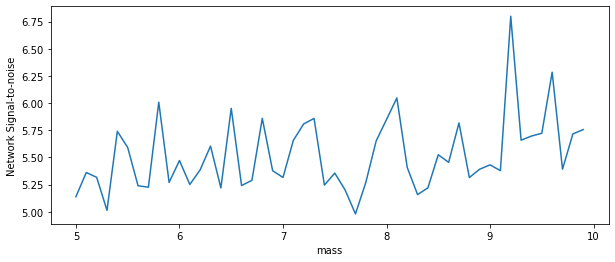

We found the best Mass1=Mass2 was 9.20 solar masses (detector frame)


In [ ]:
# print Best fit
nsnr = numpy.array(snrs)
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

In [ ]:
#As snr is above 8 (9.2) we may have a sinal

In [ ]:
import pycbc.psd
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()

